In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt

загрузка данных

In [2]:
data = pd.read_csv('com_data/com_data_20250505_015949_011.csv')
short_data = data[(data['Timestamp'] > '2025-05-05 02:30:00') & (data['Timestamp'] < '2025-05-05 02:40:00')]

In [3]:
x = short_data['Timestamp']
y = short_data['COM_Data']

# создание регрессии

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Создание полиномиальных признаков
poly = PolynomialFeatures(degree=10, include_bias=False)
# Используем индексы как признак X вместо временных меток
X = np.arange(len(y)).reshape(-1, 1)
X_poly = poly.fit_transform(X)

# Обучение модели
model = LinearRegression()
# Обучаем на правильных данных: X_poly -> y (COM_Data)
model.fit(X_poly, y)

# Предсказание
y_pred = model.predict(X_poly)

# Визуализация
plt.figure(figsize=(15, 5))
plt.plot(short_data['Timestamp'], y, color='blue', alpha=0.5, label='Исходные данные')
plt.plot(short_data['Timestamp'], y_pred, color='red', label='Регрессия')
plt.xlabel('Время')
plt.ylabel('COM_Data')
plt.legend()
plt.grid(True)
plt.show()

# Определение пиков

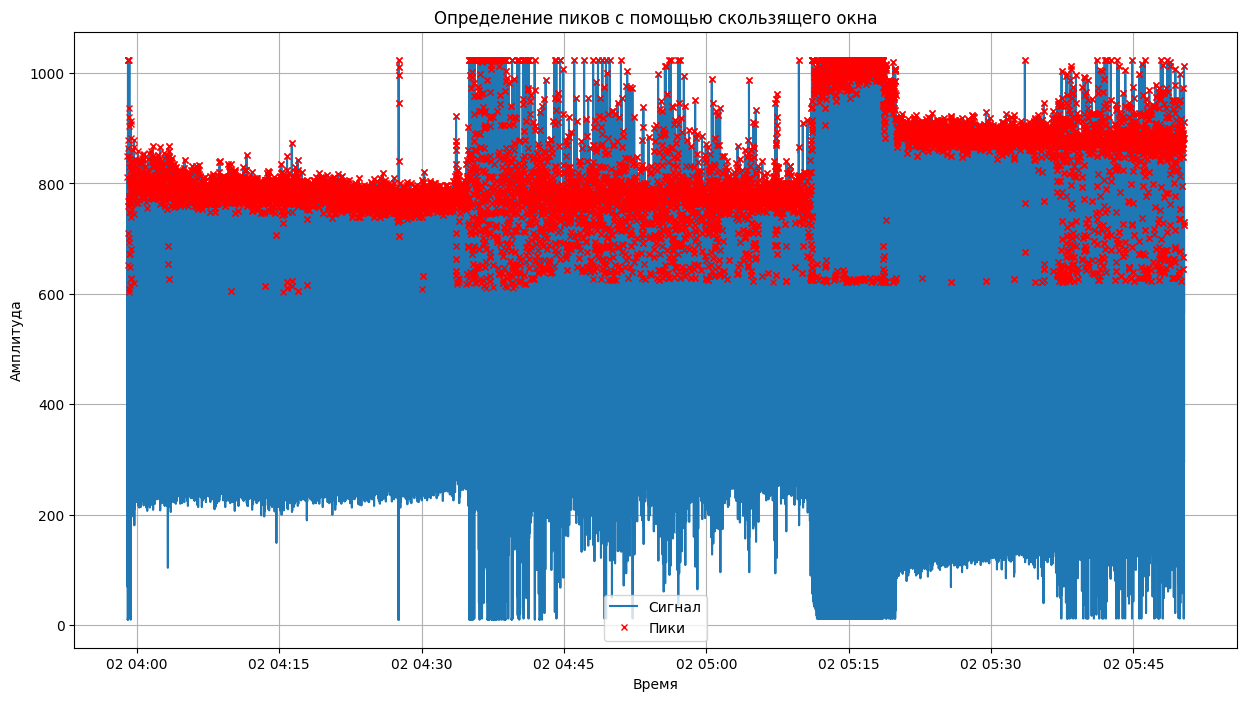

Найдено пиков: 16821


In [ ]:
# Определение параметров окна
window_size = pd.Timedelta(minutes=5)
start_time = short_data['Timestamp'].min()
end_time = short_data['Timestamp'].max()

# Создаем список для хранения всех найденных пиков
all_peaks = []

# Проходим по данным окнами
current_time = start_time
while current_time < end_time:
    window_end = current_time + window_size
    
    # Выбираем данные для текущего окна
    mask = (short_data['Timestamp'] >= current_time) & (short_data['Timestamp'] < window_end)
    window_data = short_data[mask].copy()
    
    if not window_data.empty:
        # Создаем регрессию для окна
        X_window = np.arange(len(window_data)).reshape(-1, 1)
        X_poly_window = poly.fit_transform(X_window)
        model_window = LinearRegression()
        model_window.fit(X_poly_window, window_data['COM_Data'])
        y_pred_window = model_window.predict(X_poly_window)
        
        # Рассчитываем порог для поиска пиков (регрессия + 15%)
        threshold = y_pred_window + (y_pred_window * 0.15)
        mean_threshold = np.mean(threshold)
        
        # Ищем пики в окне
        window_peaks, _ = find_peaks(window_data['COM_Data'].values, 
                                   height=mean_threshold,
                                   distance=10,
                                   prominence=100)
        
        # Сохраняем индексы найденных пиков
        all_peaks.extend(window_data.index[window_peaks])
    
    # Сдвигаем окно (с перекрытием 50%)
    current_time += window_size / 2

# Преобразуем список пиков в массив numpy
peaks = np.array(all_peaks)
peaks.sort()

# Визуализация с пиками
plt.figure(figsize=(15, 8))
plt.plot(short_data['Timestamp'], short_data['COM_Data'], label="Сигнал")
plt.plot(short_data['Timestamp'][peaks], short_data['COM_Data'].iloc[peaks], 
         "x", color='red', label="Пики", markersize=5)
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Определение пиков с помощью скользящего окна")
plt.legend()
plt.grid(True)
plt.show()

# Выводим количество найденных пиков
print(f"Найдено пиков: {len(peaks)}")